![alt text](https://raw.githubusercontent.com/louweal/wordgame/master/reports/figures/music_wordclou.png "Word Association Analysis")

# Word Association Analysis

    Anneloes Louwe 
    https://www.github.com/louweal

## Introduction
In this notebook we analyse word associations from online word association games. The word association game is a game frequently played on internet forums. In this game, each player posts a word that was his (first) association for the word in the previous post (e.g. user1 writes 'green', user2 posts 'grass', user3 posts 'tree' and so on). 

We analyse these word associations to obtain new insights into structure of the mental lexicon and simply because it is fun to analyse this type of data. ;)

## Dataset
We collected this data in 2017 using ScraPy (web scraping) from multiple sources. All data was shuffled and anonymized. 

The dataset contains the following five columns:
- _author_ : an numeric identifier for each user
- _word1_ : the cue
- _word2_ : the association
- _source_ : abbreviation of the source name 
- _sourceID_ : an numeric identifier for the source

In [19]:
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
df = pd.read_csv('../data/processed/wordgame_20180814.csv') 
pal = sns.color_palette("Paired", 10) # color palette
df.sample(5, random_state=24)

The number of word associations in this dataset:

In [8]:
len(df)

342267

The word associations are scraped from the following sources:
- AC : AspiesCentral (https://www.autismforums.com/forums/)
- BC : BleepingComputer (https://www.bleepingcomputer.com/forums/)
- CC : ClassicComics (https://classiccomics.org/)
- ECF : E-CigaretteForum (https://www.e-cigarette-forum.com/)
- GOG : Online game store (https://www.gog.com/forum)
- LEF : Learn English Forum (https://learnenglish.vanillacommunity.com) 
- SAS : Social Anxiety Support (https://www.socialanxietysupport.com/forum/)
- TF : The Fishy (https://forum.thefishy.co.uk/) 
- U2 : @U2 Forum (https://forum.atu2.com/)
- WP : Wrong Planet (https://wrongplanet.net/forums/)

Most data is (American) English and includes post from people from many different countries. LEF is a forum for people who want to learn English and therefore word associations from this source could contain more mistakes. Data from TF contains British English, since this is a forum for British football supporters. AC and WP are internet forums for people with autism, which might also effect the type of word associations. 

Number of word association from each source:

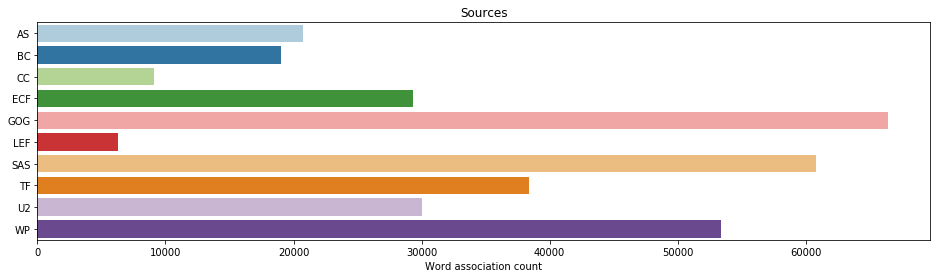

In [293]:
sources_names = ["AS", "BC", "CC","ECF","GOG","LEF","SAS","TF","U2","WP"] 
plt.figure(figsize=(16, 4))
sns.barplot(df.source.value_counts().sort_index(), sources_names, orient="h", palette=pal)
plt.title("Sources")
plt.xlabel('Word association count')
plt.show()

Number of unique users:

In [26]:
len(df.author.unique())

6386

Distribution of word association count per user:

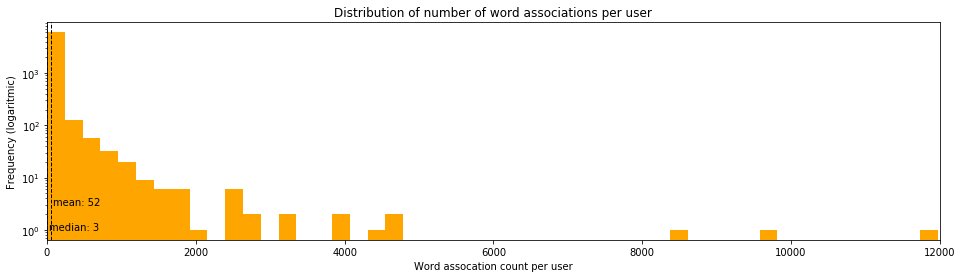

In [334]:
plt.figure(figsize=(16, 4))
median_wa = df.author.value_counts().median()
mean_wa = df.author.value_counts().mean()
plt.axvline(median_wa, color='k', linestyle='dashed', linewidth=1)
plt.text(median_wa+30, 1, "median: "+str(int(median_wa)))
plt.axvline(mean_wa, color='k', linestyle='dashed', linewidth=1)
plt.text(mean_wa+30, 3, "mean: "+str(int(mean_wa)))
g= plt.hist(df.author.value_counts(), bins=50, color="orange")
ax = plt.gca()
#ax.set_xscale('log')
ax.set_yscale('log')
plt.title('Distribution of number of word associations per user')
plt.xlabel('Word assocation count per user')
plt.ylabel('Frequency (logaritmic)')
plt.gca()
plt.xlim([1, 12000])
plt.show()

## Methodology

In [71]:
import numpy as np # linear algebra
import matplotlib.pyplot as plt # plotting
import seaborn as sns # data visualization
from collections import Counter
import os
import csv
from gensim.models import Word2Vec
from sklearn.manifold import TSNE

### Data cleaning

In [4]:
def preprocess(x):
    # replace
    x = x.replace('\n'," ") # (wrongplanet)
    x = x.replace("`", "'")
    x = x.replace("$$", "$") #allows $-signs but not multiple

    #remove 
    for symbol in ["_","~","^","xd"]:
        x = x.replace(symbol, "")
        
    if(x.find("said:") > 1):  #classic comics: removes posts containing quotes
        return ''
    
    # remove everything following ...
    for symbol in ["quote:","sent from my","edited by","posted via",
                   "/","(",",","*","\u00a0","--","*",'"',".","!","?","=","[","{",":",";",">","<"]:
        x = x.split(symbol)[0]

    #remove leading characters
    for symbol in ["+","-","&","'"," "]:
        x = x.lstrip(symbol)

    #remove trailing characters
    for symbol in ["-m", "'", " ", '\u00a0']:
        x = x.rstrip(symbol)
    return x

# convert word columns to string
df['word1'] = df['word1'].astype(str) 
df['word2'] = df['word2'].astype(str)

# delete all words containing non-ascii characters
df['word1'] = df['word1'].apply(lambda x: bytes(x, 'utf-8').decode('ascii','ignore'))
df['word2'] = df['word2'].apply(lambda x: bytes(x, 'utf-8').decode('ascii','ignore'))

#convert all to lowercase
df['word1'] = df['word1'].apply(lambda x: x.lower())
df['word2'] = df['word2'].apply(lambda x: x.lower())

# clean data
df['word1'] = df['word1'].apply(lambda x: preprocess(x))
df['word2'] = df['word2'].apply(lambda x: preprocess(x))

# replace empty word with np.NaN
df = df.replace('',np.NaN)

# drop all pairs containing NaN values
df = df.dropna(axis=0, how='any').reset_index(drop=True)

# cut off all data longer than 25 characters, since words are rarely longer 
df['word1'] = df['word1'].apply(lambda x: x[:25] if len(x)>25 else x)
df['word2'] = df['word2'].apply(lambda x: x[:25] if len(x)>25 else x)

# remove pairs with identical words
df = df[df.word1 != df.word2]

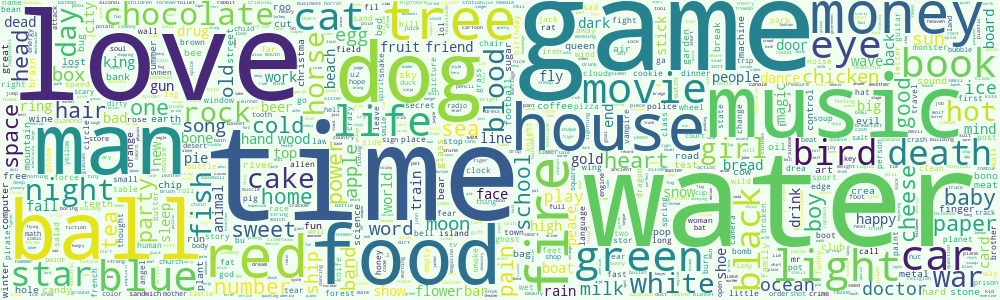

In [304]:
#from wordcloud import WordCloud
# Join the different processed titles together.
#long_string = ','.join(list(df['word2'].values))
# Create a WordCloud object
wordcloud = WordCloud(background_color="honeydew", width=1000, height=300, max_words=5000, random_state=24)
# Generate a word cloud
wordcloud.generate(long_string)
# Visualize the word cloud
wordcloud.to_image()

In [297]:
## save cleaned/preprocessed data
df.to_csv("../data/processed/wordgame_20200515_pr.csv", sep=',', index=False)

### Word frequency

Number of unique words:

In [301]:
len(df.drop_duplicates(['word2']))

60917

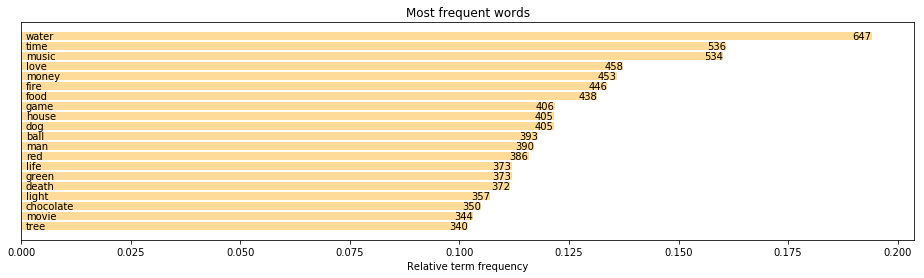

In [5]:
# compute term frequency (TF) feature
num_terms = len(df)
df['tf'] = df.groupby(['word2'])['word2'].transform('count')
df['rtf'] = df.tf.apply(lambda x: x*100/num_terms) # relative term frequency (percentage!)
frequent_words = df.drop_duplicates(subset=['word2']).sort_values(by=['tf'], ascending=False).head(20)
frequent_words = frequent_words[::-1] # reverse 

fig, ax = plt.subplots(figsize=(16, 4))
ax.clear()
ax.barh(frequent_words.word2, frequent_words.rtf, color="orange", alpha=0.4)
for i in range(0,len(frequent_words)):
    ax.text(frequent_words.rtf.iloc[i], i, frequent_words.tf.iloc[i], ha='right', va='center')
    ax.text(0.001, i, frequent_words.word2.iloc[i], ha='left', va='center') 
ax.set_yticks([])
plt.title("Most frequent words")
plt.xlabel('Relative term frequency')
plt.ylabel('')
plt.show()

##### Zipfs law
According to Zipfs law, the frequency of any word (in a large sample of words) is inversely
proportional to its rank in the frequency. 

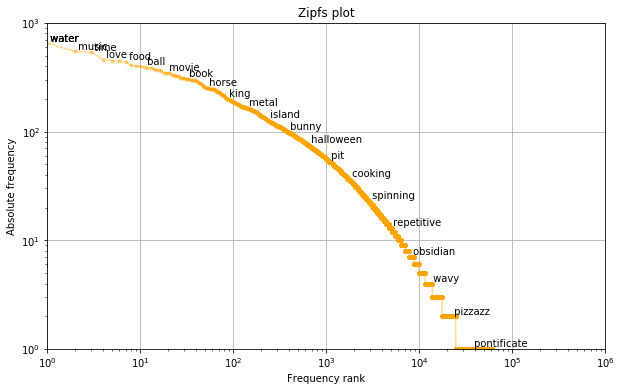

In [93]:
counts = np.array(df.word1.value_counts())
tokens = np.array(df.word1.value_counts().index)
ranks = np.arange(1, len(counts)+1)
indices = np.argsort(-counts)
frequencies = counts[indices]

plt.figure(figsize=(10, 6))
#plt.plot([1, 10e2], [10e2, 1], color='grey', linestyle='--', linewidth=1) # adds a diagonal line to the plot
plt.loglog(ranks, frequencies, marker=".", alpha=0.4, c="orange")
for n in list(np.logspace(-0.5, np.log10(len(counts)), 25).astype(int))[:-1]:
    dummy = plt.text(ranks[n], frequencies[n], " " + tokens[indices[n]], verticalalignment="bottom", 
                     horizontalalignment="left")
plt.title("Zipfs plot")
plt.xlabel("Frequency rank")
plt.ylabel("Absolute frequency")
plt.xlim(1, 10e5)
plt.ylim(1, 10e2)
plt.grid(True)
plt.show()

### Word association frequency

In [14]:
df['pair'] = df.apply(lambda x: str(x.word1) + ":" + str(x.word2), axis=1)
df['pf'] = df.groupby(['pair'])['pair'].transform('count')
df['rpf'] = df.pf.apply(lambda x: x*100/num_terms) # 

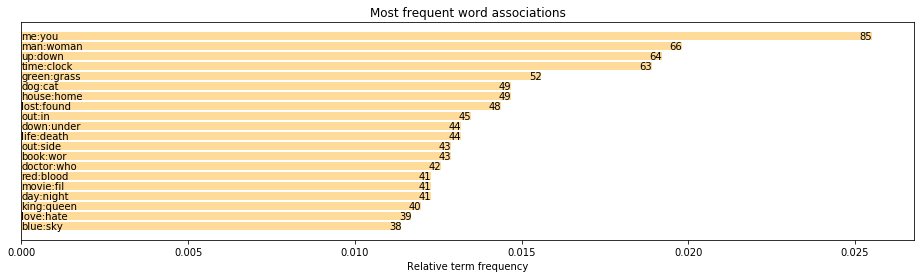

In [15]:
frequent_pairs = df.drop_duplicates(subset=['pair']).sort_values(by=['pf'], ascending=False).head(20)
frequent_pairs = frequent_pairs[::-1]

fig, ax = plt.subplots(figsize=(16, 4))
ax.clear()
ax.barh(frequent_pairs.word2, frequent_pairs.rpf, color="orange", alpha=0.4)
for i in range(0,len(frequent_pairs)):
    ax.text(frequent_pairs.rpf.iloc[i], i, frequent_pairs.pf.iloc[i], ha='right', va='center')
    ax.text(0, i, frequent_pairs.pair.iloc[i], ha='left', va='center') 
ax.set_yticks([])
plt.title("Most frequent word associations")
plt.xlabel('Relative term frequency')
plt.ylabel('')
plt.show()

## Feature Extraction

### Syntactic Features
#### Word length

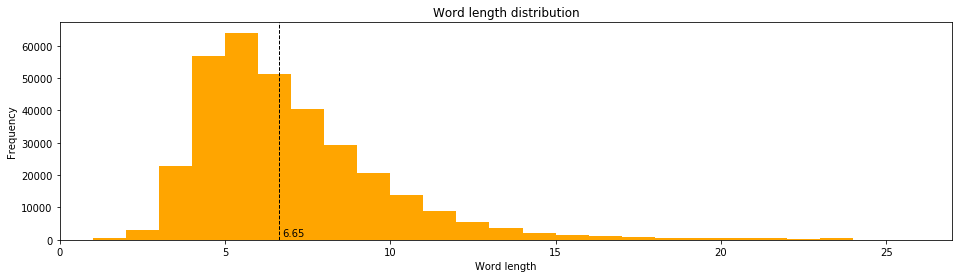

In [94]:
df['len1'] = df['word1'].apply(lambda x:len(x))
df['len2'] = df['word2'].apply(lambda x:len(x))
df['ldiff'] = abs(df['len1'] - df['len2']) # length difference between word1 and word2 

plt.figure(figsize=(16, 4))
f = plt.hist(df.len2, bins=np.arange(0,25), color='orange') 
plt.axvline(df.len2.mean(), color='k', linestyle='dashed', linewidth=1)
plt.text(df.len2.mean()+0.1, 1000, str(round(df.len2.mean(),2)))
plt.title('Word length distribution')
plt.xlabel('Word length')
plt.ylabel('Frequency')
axes = plt.gca()
axes.set_xlim([0,27])
plt.show()

### Common affixes
Word association can be either semantical (e.g. 'blue' -> 'sky') or syntactic (e.g. *'bowels' -> 'vowels'*). Here we find the common prefixes and suffixes (e.g. in the previous example the suffix is *'owels'*) and the length of these common affixes.

In [78]:
# find common prefix
df['prefix'] = df.apply(lambda r: os.path.commonprefix([r.word1, r.word2]), axis=1)
df['pl']= (df['prefix'].apply(lambda x: len(x))) # compute common prefix length

# find common suffix
df['suffix'] = df.apply(lambda r: os.path.commonprefix([r.word1[::-1], r.word2[::-1]]), axis=1)
df['suffix'] = df['suffix'].apply(lambda x:x[::-1]) #un-reverse suffix
df['sl']= (df['suffix'].apply(lambda x: len(x))) # compute common affix length

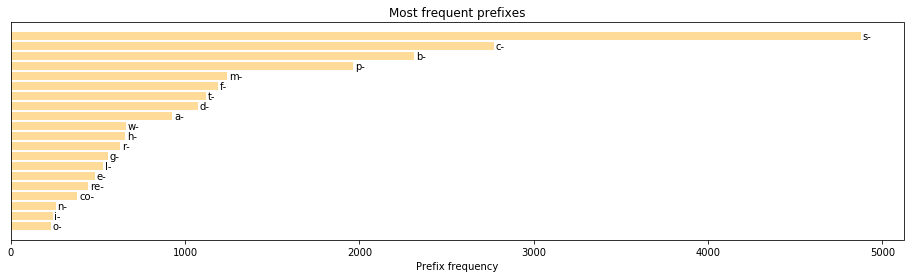

In [81]:
frequent_prefixes = pd.DataFrame(df.prefix.value_counts()[1::].head(20))
frequent_prefixes['pc'] = frequent_prefixes['prefix']
frequent_prefixes['prefix'] = frequent_prefixes.index
frequent_prefixes = frequent_prefixes.iloc[::-1] # reverse dataframe

fig, ax = plt.subplots(figsize=(16, 4))
ax.clear()
ax.barh(frequent_prefixes.prefix, frequent_prefixes.pc, color="orange", alpha=0.4)
for i in range(0, len(frequent_prefixes)):
    ax.text(frequent_prefixes.pc.iloc[i]+10, i, frequent_prefixes.prefix.iloc[i]+"-", ha='left', va='center')
ax.set_yticks([])
plt.title("Most frequent prefixes")
plt.xlabel('Prefix frequency')
plt.ylabel('')
plt.show()

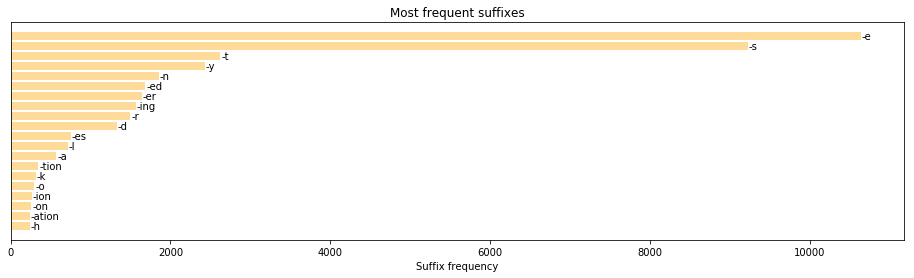

In [82]:
frequent_suffixes = pd.DataFrame(df.suffix.value_counts()[1::].head(20))
frequent_suffixes['sc'] = frequent_suffixes['suffix']
frequent_suffixes['suffix'] = frequent_suffixes.index
frequent_suffixes = frequent_suffixes.iloc[::-1] # reverse dataframe

fig, ax = plt.subplots(figsize=(16, 4))
ax.clear()
ax.barh(frequent_suffixes.suffix, frequent_suffixes.sc, color="orange", alpha=0.4)
for i in range(0, len(frequent_suffixes)):
    ax.text(frequent_suffixes.sc.iloc[i]+10, i,  "-"+frequent_suffixes.suffix.iloc[i], ha='left', va='center')
ax.set_yticks([])
plt.title("Most frequent suffixes")
plt.xlabel('Suffix frequency')
plt.ylabel('')
plt.show()

### Levenstein Distance

Levenshtein distance (also called Edit Distance) is a measure of the similarity between two strings. It is minimum the number of deletions, insertions, or substitutions required to transform the first string into the second.

In [76]:
import Levenshtein
df['edit'] = df.apply(lambda r:Levenshtein.distance(r.word1, r.word2), axis=1)
# rough normalization of edit distances
df['norm_edit'] = df.apply(lambda r:r.edit/max(r.len1,r.len2), axis=1) 

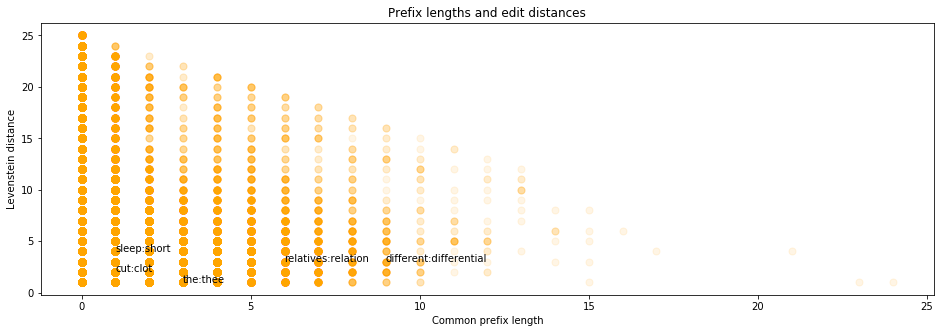

In [161]:
# prepare df for annotation
editdf = df.drop_duplicates(['pair'])

fig, ax = plt.subplots()
fig.set_figwidth(16)
fig.set_figheight(5)

# scatter all points (including duplicate pairs)
ax.scatter(df.pl, df.edit, alpha=0.1, s=50, c="orange")

# annotate unique points only
for i in range(0, len(editdf), 2800):
    if editdf.pl.iloc[i] > 0 and editdf.edit.iloc[i] < 6:
        ax.annotate(editdf.pair.iloc[i], (editdf.pl.iloc[i], editdf.edit.iloc[i]))
        
plt.title("Prefix lengths and edit distances")
plt.xlabel("Common prefix length")
plt.ylabel("Levenstein distance")
plt.show()

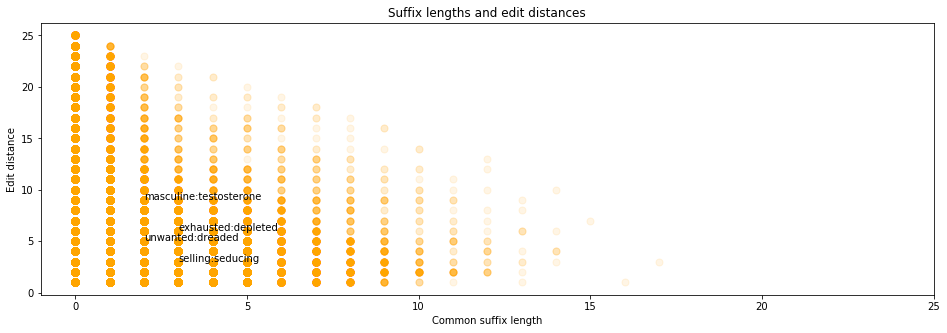

In [257]:
fig, ax = plt.subplots()
fig.set_figwidth(16)
fig.set_figheight(5)
ax.scatter(df.sl, df.edit, alpha=0.1, s=50, c="orange")

for i in range(0, len(editdf),2507):
    if editdf.sl.iloc[i] > 1 and editdf.edit.iloc[i] < 10:
        ax.annotate(editdf.pair.iloc[i], (editdf.sl.iloc[i], editdf.edit.iloc[i]))
plt.title("Suffix lengths and edit distances")
plt.xlabel("Common suffix length")
plt.ylabel("Edit distance")
#ax.gca()
plt.xlim([-1,25])
plt.show()

In [144]:
len(editdf)

249387

This concludes the syntactic feature extraction. In the next section we move on to the semantic features such as word similarity. :)

## Semantic Features
Here we extract features related to word meaning. We start with word embedding models.

### Word Embedding Model (Word2Vec)

In [ ]:
# create the documents for model training
copydf = df.copy() # copy the data
copydf['word2'] = copydf.word2.apply(lambda x: [x]) 
clouddf = copydf.groupby(['word1']).agg({'word2':'sum'}).reset_index() # group by cue
# add cue word also to word list, as many times as it has associations
clouddf['document'] = clouddf.apply(lambda r: [r.word1]*len(r.word2) + r['word2'], axis=1)

In [397]:
# create W2V model
w2v_model = Word2Vec(clouddf.document, size=300, min_count=1, sg=1, workers=10)

In [398]:
# create word corpus
corpus = list((dict(Counter(df.word1.tolist()).most_common()).keys()))[::-1]

# add word vector to 4000 most frequent words (t-sne can't handle the full dataset)
corpusdf = pd.DataFrame(corpus[-4000::], columns=['word'])
corpusdf['wordvector'] = corpusdf.word.apply(lambda x: w2v_model.wv[x])

# Compute reduced word-vectors using t-sne
tsnemodel = TSNE(random_state=42).fit_transform(corpusdf['wordvector'].tolist()) 
corpusdf['x'] = tsnemodel[:,0]
corpusdf['y'] = tsnemodel[:,1]

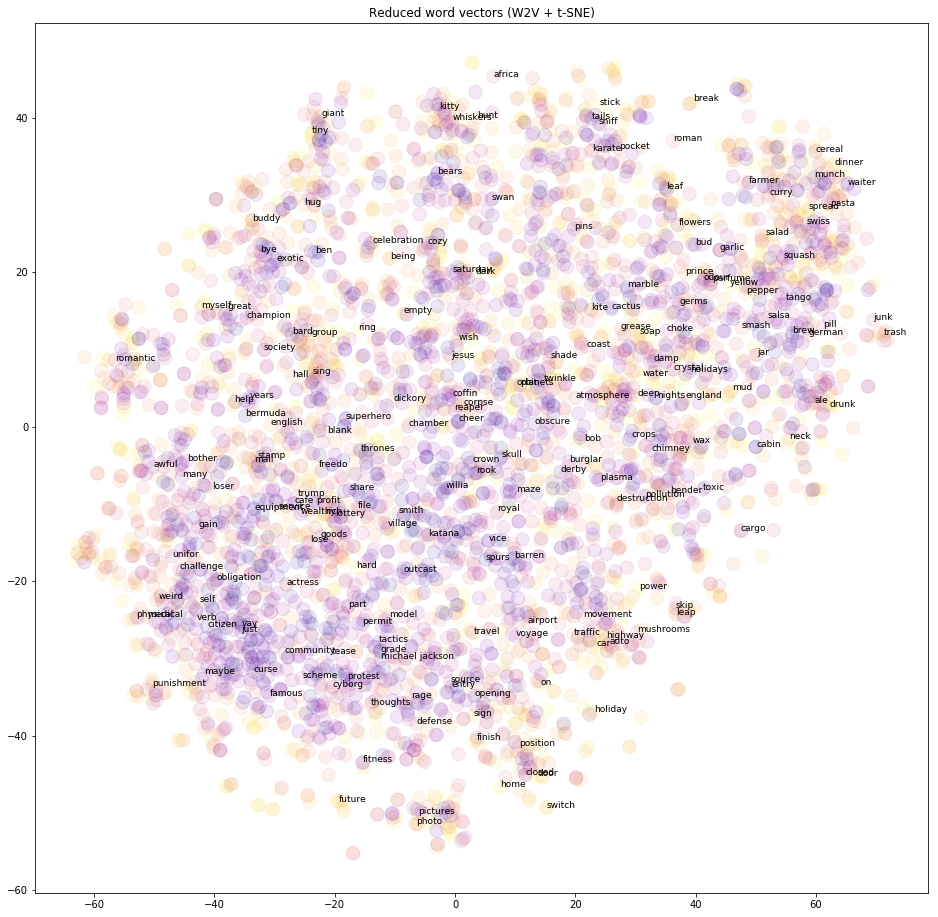

In [402]:
# plot 
corpusdf = corpusdf[::-1] # reverse
fig, ax = plt.subplots()
fig.set_figwidth(16)
fig.set_figheight(16)
sc = ax.scatter(corpusdf.y, corpusdf.x, marker='o', c=corpusdf.index, 
                cmap=plt.get_cmap('plasma'), s=180, alpha=0.1)
for j in range(0,4000,19): #len(corpusdf), 20):
    ax.annotate(corpusdf.word.iloc[j], (corpusdf.y.iloc[j], corpusdf.x.iloc[j]), fontsize='9')
plt.title("Reduced word vectors (W2V + t-SNE)")
plt.show()

In [403]:
df['sim'] = df.apply(lambda r:w2v_model.wv.similarity(r.word1, r.word2), axis=1)

/home/anneloes/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:1: DeprecationWarning: Call to deprecated `similarity` (Method will be removed in 4.0.0, use self.wv.similarity() instead).
  """Entry point for launching an IPython kernel.


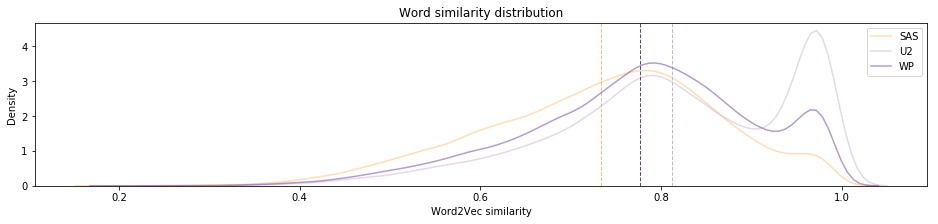

In [418]:
plt.figure(figsize=(16, 3))
for i in [6,8,9]:
    s = df[df['sourceID']==i]
    plt.axvline(s.sim.mean(), color=pal[i], linestyle='dashed', linewidth=1)
    sns.kdeplot(s.sim, label=s.iloc[0]['source'], alpha=0.5, color=pal[i])  
plt.title('Word similarity distribution')
plt.xlabel("Word2Vec similarity")
plt.ylabel('Density')
plt.legend(loc='upper right')
plt.show()

In [436]:
df[['source','pair','sim']].drop_duplicates(subset=['pair']).sort_values(by=['sim'], ascending=False).head(5)

,source,pair,sim
244794,TF,comedy gold:fools + horses,0.997053
287548,AC,blowhard:boastful,0.997038
227896,GOG,mope:sulk,0.996908
1089,GOG,preeminent:distinguished,0.996790
116856,GOG,eskimos:igloos,0.996683


### Pre-trained Word Embedding model
Next make a more semantically meaningful word embedding, that is not influenced by the word frequencies in the dataset, by using a pre-trained model that is trained on different data. We use this pre-trained Google News corpus word vector model: https://drive.google.com/file/d/0B7XkCwpI5KDYNlNUTTlSS21pQmM/edit.

In [11]:
from gensim.models.keyedvectors import KeyedVectors
# this might take a while, and requires a computer with a decent amount of memory (16+ GB)
w2v_news_model = KeyedVectors.load_word2vec_format('../data/external/GoogleNews-vectors-negative300.bin', binary=True)

In [12]:
# replace spaces by underscores (word2vec convention)
df['word1w2v'] = df.word1.apply(lambda x:(x.replace(" ", "_")))
df['word2w2v'] = df.word2.apply(lambda x:(x.replace(" ", "_"))) 
# check if model contains words
df['inw2v1'] = df['word1w2v'].apply(lambda x:(x in w2v_news_model.vocab))
df['inw2v2'] = df['word2w2v'].apply(lambda x:(x in w2v_news_model.vocab)) 
print("Percentage found: " + str(df.inw2v1.sum()*100/len(df)))

# apply title capitilization to words not found in the model
df.loc[~df.inw2v1, 'word1w2v'] = df.loc[~df.inw2v1].word1w2v.apply(lambda x:x.title())
df.loc[~df.inw2v2, 'word2w2v'] = df.loc[~df.inw2v2].word2.apply(lambda x:x.title())
# check if model contains the words (again)
df['inw2v1'] = df['word1w2v'].apply(lambda x:(x in w2v_news_model.vocab))
df['inw2v2'] = df['word2w2v'].apply(lambda x:(x in w2v_news_model.vocab))
print("Percentage found: " + str(df.inw2v1.sum()*100/len(df)))

# uppercase words not found in the model
df.loc[~df.inw2v1, 'word1w2v'] = df.loc[~df.inw2v1].word1w2v.apply(lambda x:x.upper())
df.loc[~df.inw2v2, 'word2w2v'] = df.loc[~df.inw2v2].word2w2v.apply(lambda x:x.upper())
# check if model contains the words (again)
df['inw2v1'] = df['word1w2v'].apply(lambda x:(x in w2v_news_model.vocab))
df['inw2v2'] = df['word2w2v'].apply(lambda x:(x in w2v_news_model.vocab))
print("Percentage found: " + str(df.inw2v1.sum()*100/len(df)))

# check if both words in words association are found
df['inw2v'] = df.apply(lambda r:(r.inw2v1 & r.inw2v2), axis=1)
df = df.drop('inw2v1', 1) # remove
df = df.drop('inw2v2', 1) # remove

Percentage found: 88.65866826634674
Percentage found: 92.07798440311937
Percentage found: 92.85092981403719


In [16]:
# compute similarity
df['news_sim'] = np.nan # similarity for unknown word pairs
df.loc[df.inw2v, 'news_sim'] = df.loc[df.inw2v].apply(lambda r:w2v_news_model.similarity(r.word1w2v, r.word2w2v), axis=1)
# show pairs with highest similarity
df.drop_duplicates(subset=['pair']).sort_values(by=['news_sim'], ascending=False).head(5).pair.tolist()

['four:three', 'three:four', 'south:north', 'north:south', 'west:east']

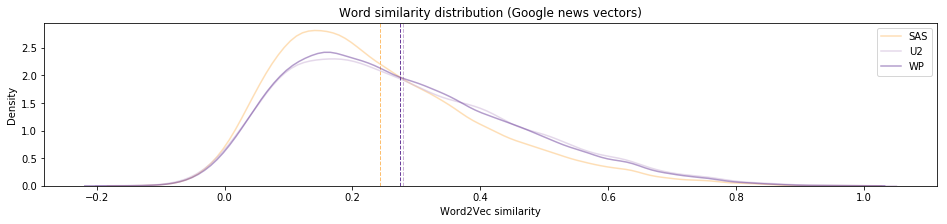

In [20]:
w2vdf = df[df.inw2v==True] # only keep pairs with similarity scores

plt.figure(figsize=(16, 3))
for i in [6,8,9]: #[3,7]: #range(0,10): #[6,8,9]:
    s = w2vdf[w2vdf['sourceID']==i]
    plt.axvline(s.news_sim.mean(), color=pal[i], linestyle='dashed', linewidth=1)
    sns.kdeplot(s.news_sim, label=s.iloc[0]['source'], alpha=0.5, color=pal[i])  
plt.title('Word similarity distribution (Google news vectors)')
plt.xlabel("Word2Vec similarity")
plt.ylabel('Density')
plt.legend(loc='upper right')
plt.show()

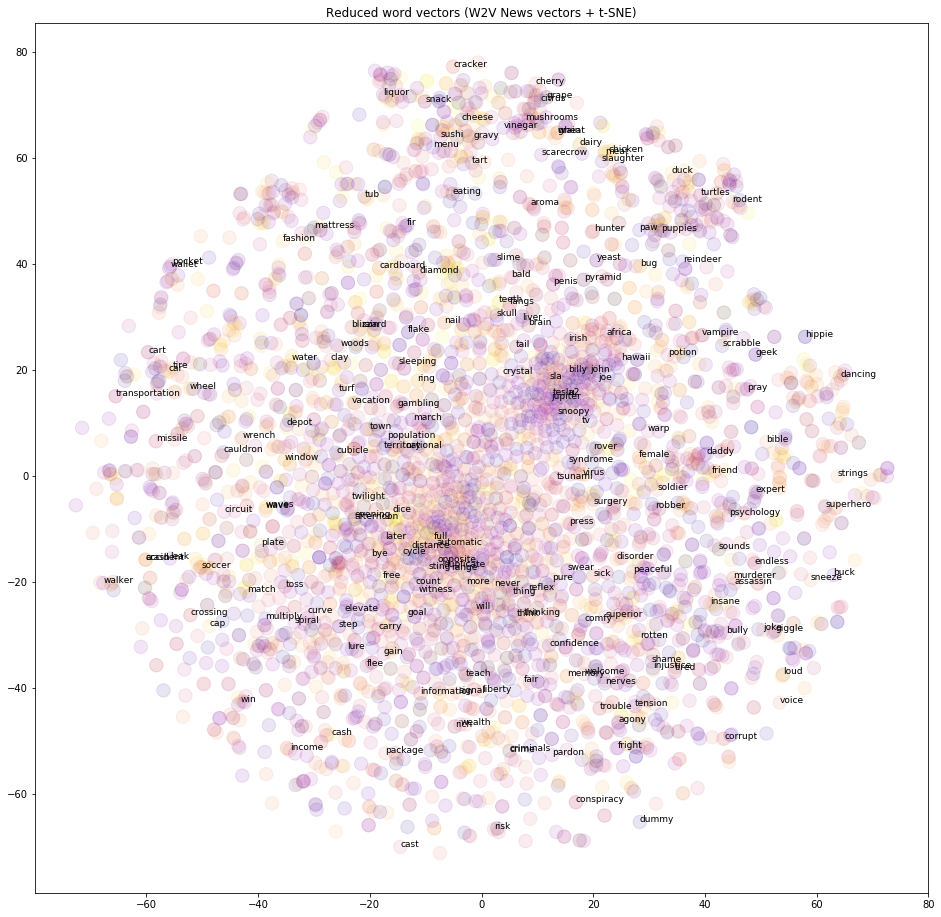

In [529]:
from sklearn.manifold import TSNE
# create word corpus
corpus = list((dict(Counter(w2vdf.word1w2v.tolist()).most_common()).keys()))[::-1]

# add word vector to 4000 most frequent words (t-sne can't handle the full dataset)
corpusdf = pd.DataFrame(corpus[-4000::], columns=['word'])
corpusdf['news_wordvector'] = corpusdf.word.apply(lambda x: w2v_news_model[x])

# Compute reduced word-vectors using t-sne
tsnemodel = TSNE(random_state=42).fit_transform(corpusdf['news_wordvector'].tolist()) 
corpusdf['x'] = tsnemodel[:,0]
corpusdf['y'] = tsnemodel[:,1]

corpusdf = corpusdf[::-1] # reverse
fig, ax = plt.subplots()
fig.set_figwidth(16)
fig.set_figheight(16)
sc = ax.scatter(corpusdf.y, corpusdf.x, marker='o', c=corpusdf.index, 
                cmap=plt.get_cmap('plasma'), s=180, alpha=0.1)
for j in range(0,4000,19): #len(corpusdf), 20):
    ax.annotate(corpusdf.word.iloc[j], (corpusdf.y.iloc[j], corpusdf.x.iloc[j]), fontsize='9')
plt.title("Reduced word vectors (W2V News vectors + t-SNE)")
plt.show()

In [518]:
df[['word1','word2','sim','news_sim']].sample(5, random_state=24)

,word1,word2,sim,news_sim
279266,clandestine,condition,0.788329,0.003567
200204,mouse,mickey,0.787722,0.036524
2171,department,store,0.845871,0.346928
36164,today,yesterday,0.862112,0.603247
44218,greet,introduce,0.930160,0.234392


### WordNet
WordNet is a lexical database for the English language. Here we use it to identify word pairs as synonyms, antonyms, hypernyms and hyponyms. We also identify nouns.

In [6]:
from itertools import chain
from nltk.corpus import wordnet

def isSynonym(r):
    synonyms = wordnet.synsets(r.word1)
    lemmas = set(chain.from_iterable([w.lemma_names() for w in synonyms]))
    return (r.word2 in lemmas)

def isAntonym(r):
    h = []
    for syn in wordnet.synsets(r.word1):
        for l in syn.lemmas():
            if l.antonyms():
                h.append(l.antonyms()[0].name().split('.')[0]) 
    return (r.word2 in h)

def isHypernym(r):
    h = []
    for syn in wordnet.synsets(r.word1):
        if syn.hypernyms():
            h.append(syn.hypernyms()[0].name().split('.')[0])
    return (r.word2 in h)

def isHyponym(r):
    h = []
    for syn in wordnet.synsets(r.word1):
        if syn.hyponyms():
            h.append(syn.hyponyms()[0].name().split('.')[0]) 
    return (r.word2 in h)

In [7]:
# identify nouns 
nouns = {x.name().split('.', 1)[0] for x in wordnet.all_synsets('n')} 
df['noun1'] = df.word1.apply(lambda x:(x in nouns)) 
df['noun2'] = df.word2.apply(lambda x:(x in nouns)) 

# identify synonyms
df['synonym'] = df.apply(isSynonym, axis=1)
# identify antonyms
df['antonym'] = df.apply(isAntonym, axis=1)
# identify hypernyms
df['hypernym'] = df.apply(isHypernym, axis=1)
# identify hyponyms
df['hyponym'] = df.apply(isHyponym, axis=1)

Percentage of pairs with semantic relationship(s): 

In [22]:
dfsem = df[df.synonym | df.antonym | df.hypernym | df.hyponym]
len(dfsem)*100/len(df)

6.48260347930414

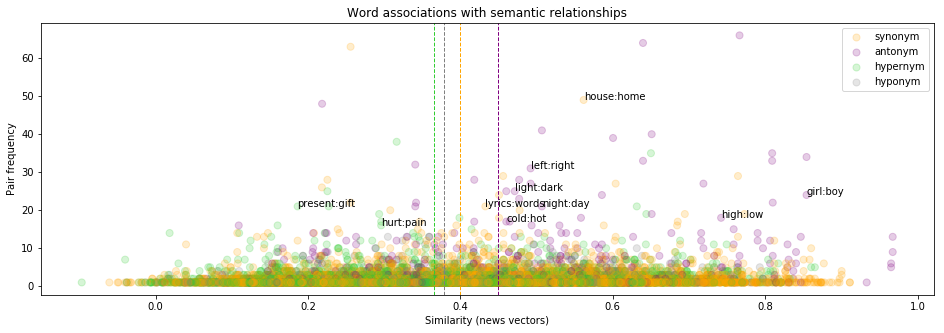

In [67]:
# prepare for plotting
semdf = dfsem[~dfsem.news_sim.isnull()].drop_duplicates(['pair'])

# some pairs multiple relationships! e.g. wound:hurt (last in this list defines its color)... 
columns = [semdf.synonym, semdf.antonym, semdf.hypernym, semdf.hyponym]
colors = ["orange", "purple", "limegreen", "grey"]

semdf['color'] = "white" # add column for colors
for i in range(0,4):
    semdf.loc[columns[i], 'color'] = colors[i]
    
#plot 
fig, ax = plt.subplots()
fig.set_figwidth(16)
fig.set_figheight(5)

# hacking some labels into the plot
for i in range(0,4):
    ax.scatter([], [], alpha=0.2, s=50, c=colors[i], label=columns[i].name)
    
# plot all points
ax.scatter(semdf.news_sim, semdf.pf, alpha=0.2, s=50, c=semdf.color, label="")

# draw mean line
for i in range(0,4):
    ax.axvline(semdf[columns[i]].news_sim.mean(), color=colors[i], linestyle='dashed', linewidth=1)

# annotate some points
for i in range(0, len(semdf), 10):
    if semdf.pf.iloc[i] > 15:
        ax.annotate(semdf.pair.iloc[i], (semdf.news_sim.iloc[i], semdf.pf.iloc[i]))
        
plt.title("Word associations with semantic relationships")
plt.xlabel("Similarity (news vectors)")
plt.ylabel("Pair frequency")
plt.legend(loc='upper right')
plt.gca()
#plt.ylim(0,700)
plt.show()

### Psycholinguistic features

#### Age-of-Acquisition
Age of Acquisition is a psycholinguistic variable referring to the age at which a word is typically learned. Source: http://crr.ugent.be/archives/806. 

In [168]:
import csv
# read AoA data
reader = csv.reader(open('../data/external/AoA_ratings_Kuperman.csv', 'r'))
# create AoA dictionary
aoa_dict = {k:v for k,v in reader if v!='NA'}
# add AoA feature to data
df['AoA'] = df['word2'].apply(lambda x:float(aoa_dict[x]) if x in aoa_dict else np.nan).astype('float') 

print("Percentage of words with known Age-of-acquisition: " + str(round(len(df[~df['AoA'].isnull()])/len(df)*100,1)))

Percentage of words with known Age-of-acquisition: 70.4


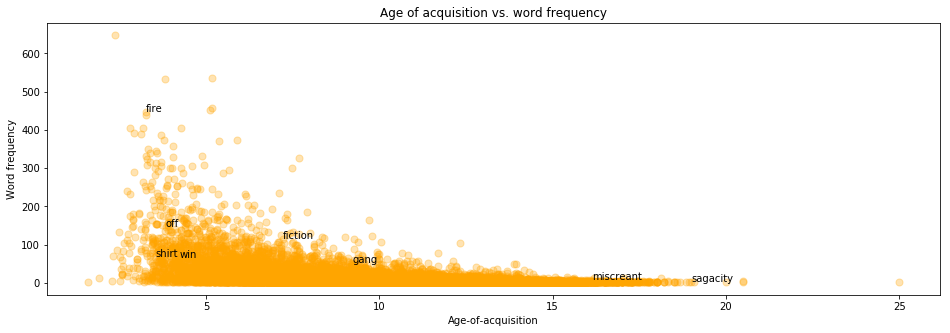

In [299]:
# prepare a df for plotting
aoadf = df[~df.AoA.isnull()].drop_duplicates(['word2'])

#plot 
fig, ax = plt.subplots()
fig.set_figwidth(16)
fig.set_figheight(5)
ax.scatter(aoadf.AoA, aoadf.tf, alpha=0.3, s=50, c="orange")
for i in range(2, len(aoadf), 176):
    if aoadf.tf.iloc[i] > 50 or aoadf.AoA.iloc[i] > 16:
        ax.annotate(aoadf.word2.iloc[i], (aoadf.AoA.iloc[i], aoadf.tf.iloc[i]))
plt.title("Age of acquisition vs. word frequency")
plt.xlabel("Age-of-acquisition")
plt.ylabel("Word frequency")
plt.show()

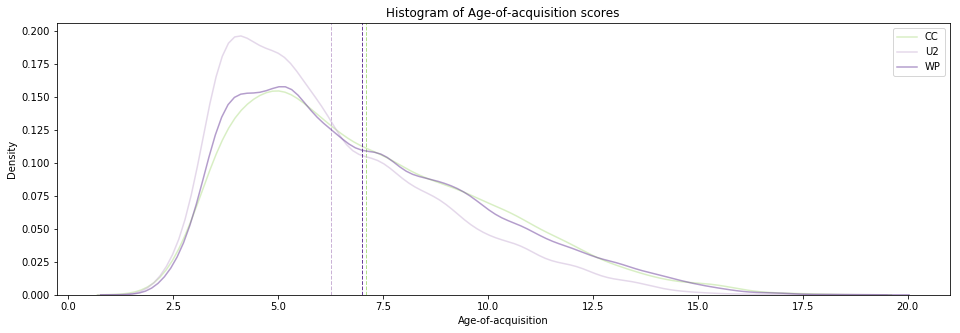

In [301]:
aoadf = df[~df.AoA.isnull()]

plt.figure(figsize=(16, 5))
for i in [2,8,9]: #range(0,10,1):
    s = aoadf[aoadf['sourceID']==i]
    plt.axvline(s.AoA.mean(), color=pal[i], linestyle='dashed', linewidth=1)
    sns.kdeplot(s['AoA'], label=s.iloc[0]['source'], alpha=0.5, color=pal[i])  
plt.title('Histogram of Age-of-acquisition scores')
plt.xlabel("Age-of-acquisition")
plt.ylabel('Density')
plt.legend(loc='upper right')
plt.show()

#### Concreteness rating
Another phycholinguistic variable is the concreteness rating. (source: http://crr.ugent.be/archives/1330). Words like 'fire' have a high concreteness rating, whereas words like 'fail' and 'generic' have low concreteness ratings. 

In [212]:
# read concreteness data
reader = csv.reader(open('../data/external/Concreteness_english.csv', 'r'))
# create concreteness dictionary
conc_dict = {k:v for k,v in reader if v!='NA'}
# add concreteness feature to data
df['CR'] = df['word2'].apply(lambda x:conc_dict.get(x)).astype('float')
# percentage of words with known concreteness rating
len(df[~df.CR.isnull()])/len(df)*100

73.46670665866827

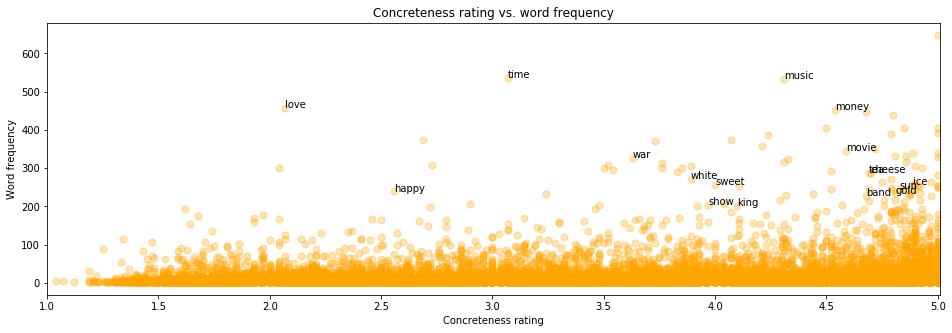

In [213]:
# prepare data for plotting
crdf = df[~df.CR.isnull()].drop_duplicates(['word2'])

# remove rows with nan aoa's
fig, ax = plt.subplots()
fig.set_figwidth(16)
fig.set_figheight(5)
ax.scatter(crdf.CR, crdf.tf, alpha=0.3, s=50, c="orange")
for i in range(0, len(crdf), 5):
    if crdf.tf.iloc[i] > 200 and crdf.CR.iloc[i] < 4.9:
        ax.annotate(crdf.word2.iloc[i], (crdf.CR.iloc[i], crdf.tf.iloc[i]))
plt.title("Concreteness rating vs. word frequency")
plt.xlabel("Concreteness rating")
#plt.xticks([1.0,5.0])
plt.ylabel("Word frequency")
plt.gca()
plt.xlim([1,5.01])
plt.show()

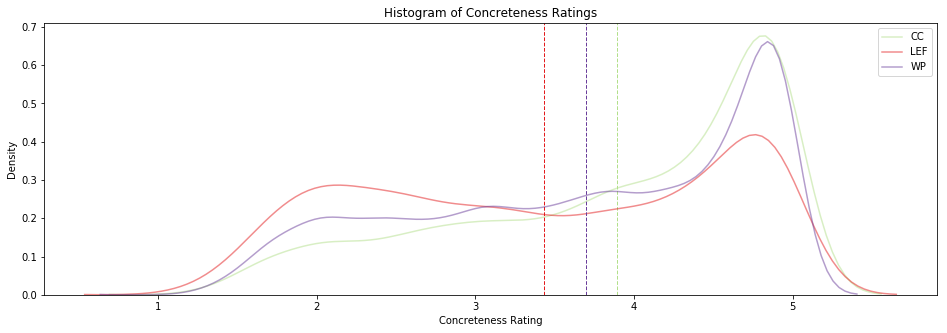

In [302]:
crdf = df[~df.CR.isnull()]

plt.figure(figsize=(16, 5))
for i in [2,5,9]: #range(0,10,1):
    s = crdf[crdf['sourceID']==i]
    plt.axvline(s.CR.mean(), color=pal[i], linestyle='dashed', linewidth=1)
    sns.kdeplot(s['CR'], alpha=0.5, label=s.iloc[0]['source'], color=pal[i])  
plt.title('Histogram of Concreteness Ratings')
plt.xlabel('Concreteness Rating')
plt.ylabel('Density')
plt.legend(loc='upper right')
plt.show()

In [583]:
# save features
df.to_csv("../data/processed/wordgame_20200315_ft.csv", sep=',', index=False)

### Topic modelling
A topic model is... 
Here we use 

In [227]:
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.decomposition import NMF #, LatentDirichletAllocation
#from gensim.models import Word2Vec
from itertools import combinations

MAX_FEATURES = 2000 # maximum number of features
TOP_WORDS = 12

# prepare data (approx similar to word2vec training)
copydf = df.copy() # copy the data

copydf['word1'] = copydf.word1.apply(lambda x:(x.replace(" ", "_")))
copydf['word2'] = copydf.word2.apply(lambda x:(x.replace(" ", "_")))

copydf['word2'] = copydf.word2.apply(lambda x: [x]) 
tmdf = copydf.groupby(['word1']).agg({'word2':'sum'}).reset_index() # group by cue
# add cue word also to word list, once
tmdf['document'] = tmdf.apply(lambda r: [r.word1] + r['word2'], axis=1)
tmdf['document'] = tmdf.document.apply(lambda x: " ".join(x))

# fit vectorizer
tfidf_vectorizer = TfidfVectorizer(analyzer = 'word', max_features=MAX_FEATURES, 
                    strip_accents = None, preprocessor=None, encoding = 'utf-8', token_pattern= "(?u)\\b[\\w-]+\\b")

tfidf = tfidf_vectorizer.fit_transform(tmdf.document)
tfidf_feature_names = tfidf_vectorizer.get_feature_names()

# create nmf model
model = NMF(n_components=40, random_state=42, alpha=.1, l1_ratio=.5, init='nndsvd') # todo
model.fit(tfidf)

In [230]:
top_terms = {}
for topic_idx, topic in enumerate(model.components_):
    #key = "topic_"+str(topic_idx)
    terms = [tfidf_feature_names[i] for i in topic.argsort()[:-TOP_WORDS - 1:-1]]
    print(topic_idx, ': ', terms)    
    top_terms[topic_idx] = terms

0 :  ['s', 'elvis', 'spider', 'cat', 'cereal', 'e', 'o', 'santa', 'two', 'fool', 'sex', 'disease']
1 :  ['i', 'fake', 'freedo', 'weird', 'piano', 'snow', 'we', 'heart', 'bad', 'old', 'tree', 'king']
2 :  ['music', 'u2', 'band', 'guitar', 'jazz', 'piano', 'lyrics', 'orchestra', 'awesome', 'noise', 'dance', 'instrument']
3 :  ['water', 'ocean', 'sea', 'stea', 'river', 'wet', 'boat', 'air', 'heat', 'sink', 'smoke', 'light']
4 :  ['money', 'bank', 'pay', 'debt', 'loan', 'rich', 'gold', 'market', 'law', 'poor', 'cash', 'business']
5 :  ['food', 'dinner', 'breakfast', 'tasty', 'feast', 'yummy', 'restaurant', 'taste', 'cook', 'meat', 'snack', 'spicy']
6 :  ['it', 'lol', 'hole', 'apple', 'park', 'garbage', 'drama', 'halloween', 'beef', 'f', 'tornado', 'mob']
7 :  ['death', 'sadness', 'time', 'old', 'mystery', 'dead', 'rope', 'black', 'medicine', 'alien', 'detective', 'murder']
8 :  ['me', 'the', 'face', 'eye', 'sad', 'who', 'dude', 'different', 'big', 'computer', 'paper', 'dance']
9 :  ['game'

In [ ]:
W = model.fit_transform(tfidf)
# add topic features to dataset
for i in range(0, 40):
    col_name = "topic_" + str(i)
    df[col_name] = W[:,i]

### Classification
For classification purposes we simply assume that all users on AC and WP have autism and all other user do not have autism.

In [163]:
df['ASD'] = df['sourceID'].apply(lambda x:int((x%9)==0)) # 0= AspiesCentral, 9=WrongPlanet
print("Percentage of data from AC and WP: " + str(round(df.ASD.mean()*100,1)))

Percentage of data from AC and WP: 22.2


In [209]:
from sklearn.preprocessing import normalize
from sklearn.linear_model import LogisticRegression
from sklearn import metrics
from sklearn.model_selection import train_test_split
from imblearn.over_sampling import SMOTE #, RandomOverSampler
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report

cols = df.drop(['news_sim','CR','AoA','ASD','word1','word2','pair','author', 'source', 'sourceID', 'inw2v','word1w2v','word2w2v','prefix','suffix'], 1).columns.tolist() 
X = df[cols].values
y = df['ASD'].values
#X = normalize(X, axis=0, norm='max')

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=12)
# fit logistic regression model
logreg = LogisticRegression(solver='lbfgs', max_iter=200)
logreg.fit(X_train, y_train)

# predict labels test set
y_pred = logreg.predict(X_test)

print("\n Confusion Matrix: \n", confusion_matrix(y_test, y_pred))
print("\n Classification Report: \n", classification_report(y_test, y_pred))


 Confusion Matrix: 
 [[64730     0]
 [18620     0]]

 Classification Report: 
               precision    recall  f1-score   support

           0       0.78      1.00      0.87     64730
           1       0.00      0.00      0.00     18620

    accuracy                           0.78     83350
   macro avg       0.39      0.50      0.44     83350
weighted avg       0.60      0.78      0.68     83350



/home/anneloes/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:947: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
/home/anneloes/anaconda3/lib/python3.7/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/home/anneloes/anaconda3/lib/python3.7/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/home/anneloes/anaconda3/lib/python3.7/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


## Results
Exploratory data analysis
- The data is extremely skewed. Most players contribute only 3 word associations (median) to the game, but some authors are almost addicted to this game. One (severely addicted) person alone accounts for 3.6% of all data (12209 posts), whereas 52 posts per author would be optimal (mean).

Word frequency
- freq words ...
- Zipfs law does not apply for word association data

Age-of-acquisition
- U2-fans (U2) are frequently using words with really low AoA scores, which might indicate that their average age is also lower

Concreteness:
- English learners use more words with low concreteness (?). 
- Many word associations from other sources have a high concreteness score (a peak near concreteness 5)

WordNet
- Only a small percentage of the word pairs appear to have semantic relationships. 

## Discussion